# **This is the Sentiment Analysis of the Webex's app reviews [Jupyter Notebook]**
### We will see how to prepare the scraped dataset and insert it into machine learning models in order to do the right predictions.
### After training the models, we are going to evaluate them and measure their effeciency on classifying each review to the right class by distinguishing the right sentiment.

### The machine learning models we are going to use are **Logistic Regression**, **SGD Classifier** and **Naive Bayes**.

Firstly, we have to import the necessary libraries

*Tip: You might need to install some packages with the pip installer to import all the libraries*

In [124]:
# basic data handling and math libraries
import numpy as np
import pandas as pd
# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# wordcloud library for visualizing most common words
from wordcloud import WordCloud, STOPWORDS
# regular expressions
import re, string, unicodedata
#Natural Language Processing libraries
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer, LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
# textblob for spelling correction
from textblob import TextBlob, Word
# spacy for lemmatization
import spacy
# Scikit-learn libraries for feature extraction and modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.pipeline import make_pipeline
# for saving models
import joblib # How to use?: joblib.dump(model, 'model.pkl'), joblib.load('model.pkl')
# to ignore warnings because they are annoying
import warnings
warnings.filterwarnings('ignore')

### For the first step, we are gonna import the data that we created in the previous notebook, in **DataFrame** format

In [125]:
webex_df = pd.read_csv('com.cisco.webex.meetings_reviews.csv')
webex_df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,56598e3f-86f2-44ff-a561-4f6d58eb7173,Wendy Rowe,This is my second time trying it on my Android...,1,6,44.9.1,2024-10-16 18:12:56,44.9.1
1,06fd6a83-ea69-4a75-af45-93f62e4adc27,Robert Jim Fulner,My company recently update the version of the ...,3,12,44.7.1,2024-08-18 15:18:44,44.7.1
2,7c9e80a3-8d54-4c4e-be76-1a045bb4f73c,Pthom Thompson,Display icons on the screen that do not have l...,3,8,44.7.0,2024-07-19 16:40:28,44.7.0
3,bb2c1106-fd82-4650-91b3-1c17616fe61c,A Google user,"Rough, to say the least. Still, my cell was ul...",3,19,39.4.0,2019-06-14 20:40:45,39.4.0
4,de6c508b-7600-4804-81e4-9d647713272f,Holly Hill,This app worked very well for me. Clear video ...,5,122,44.4.0,2024-05-06 19:10:51,44.4.0


### Now we are going to perform some **Exploratory Data Analysis (EDA)**

In [126]:
webex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30049 entries, 0 to 30048
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              30049 non-null  object
 1   userName              30049 non-null  object
 2   content               30049 non-null  object
 3   score                 30049 non-null  int64 
 4   thumbsUpCount         30049 non-null  int64 
 5   reviewCreatedVersion  27648 non-null  object
 6   at                    30049 non-null  object
 7   appVersion            27648 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.8+ MB


In [127]:
webex_df.describe()

,score,thumbsUpCount
count,30049.000000,30049.000000
mean,3.471763,5.190921
std,1.539573,54.909012
min,1.000000,0.000000
25%,2.000000,0.000000
50%,4.000000,0.000000
75%,5.000000,0.000000
max,5.000000,3180.000000


In [128]:
webex_df['score'].value_counts()

score
5    11265
4     6240
1     6008
3     3958
2     2578
Name: count, dtype: int64

In [129]:
webex_df.isnull().sum()

reviewId                   0
userName                   0
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    2401
at                         0
appVersion              2401
dtype: int64

### Now we have to keep only the important features for the sentiment analysis task, which are the review strings and the score.
- In this case, we will label scores [4, 5] "positive" and [1, 2] "negative". Scores with value [3] will be labelled as "neutral" but we are not gonna use them anyway as they may prove misleading.


*for a more obvious feature separation, we can keep the scores 1 and 5 ("negative", "positive") only*

In [130]:
webex_df = webex_df[['content', 'score']]
webex_df['score'] = webex_df['score'].apply(lambda x: 'positive' if x >= 4 else('negative' if x <= 2 else 'neutral'))

webex_df['score'].value_counts()

score
positive    17505
negative     8586
neutral      3958
Name: count, dtype: int64

In [131]:
webex_df = webex_df[(webex_df['score'] == 'positive') | (webex_df['score'] == 'negative')]

webex_df['score'].value_counts()

score
positive    17505
negative     8586
Name: count, dtype: int64

In [132]:
webex_df.shape

(26091, 2)

## Now we are moving to the text's normalization
- ### First we use the `ToktokTokenizer` to break text into individual tokens while preserving important linguistic features.
- ### Then we create a list of English stop words using the `nltk` library in order to remove these words and help focus on the meaningful content that actually express sentiment.

In [133]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

### To remove special characters: (digits are optional, we have set it `True`) We need to clean the DataFrame for further processing which will ensure that the data is normalized and free of unneccesary noise.

In [134]:
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-Z\s]' if remove_digits else r'[^a-zA-Z0-9\s]'
    return re.sub(pattern, '', text)

webex_df['content'] = webex_df['content'].apply(lambda x: remove_special_characters(x))

### Displaying the first review to verify that no special characters or digits exist.

In [135]:
webex_df['content'].iloc[1]

'This app worked very well for me Clear video and sound and all of the functions pause video or microphone etc worked well and right as you selected them The only issue I had was when I tried to remove the blurred background to select none it would not apply I tried multiple times All of the other backgrounds worked fine as far as I could tell but I never applied them I could see them in the preview mode The only selection that did not work was none no background'

### Lemmatization 
**!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!**

(*We can skip because classifiers can learn word-sentiment relashionships directly from the labeled data and modern deep learning models can handle word variations well*)

### Nevertheless, we can still use this function for lemmatization, as we can reduce words to their root forms and imporve the quality of features for other NLP tasks, as it ensures consistency. In this case though, we don't need to do it as this method proves useful in non-labeled data, but our dataset is already labeled with the sentiment score of each review.

In [136]:
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#
## Get wordnet POS tag
#def get_wordnet_pos(word):
#    tag = nltk.pos_tag([word])[0][1][0].upper()
#    tag_dict = {"J": wordnet.ADJ,
#                "N": wordnet.NOUN,
#                "V": wordnet.VERB,
#                "R": wordnet.ADV}
#    return tag_dict.get(tag, wordnet.NOUN)
#
## Lemmatization function
#def lemmatize_text(text):
#    lemmatizer = WordNetLemmatizer()
#    return ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) 
#                    for word in text.split()])
#
#webex_df['content'] = webex_df['content'].apply(lemmatize_text)

### Removing Stopwords

**!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!**

(*We can skip this too*)

### We can uncomment the code cell if we decide that by removing stopwords, we will improve the efficiency of the ML models. For instance, we can reduce the frequency of non-informative words and improve the focus on significant terms for TF-IDF vectorization tasks.

In [137]:
##set stopwords to english
#stop=set(stopwords.words('english'))
#print(stop)
#
##removing the stopwords
#def remove_stopwords(text, is_lower_case=False):
#    tokens = tokenizer.tokenize(text)
#    tokens = [token.strip() for token in tokens]
#    if is_lower_case:
#        filtered_tokens = [token for token in tokens if token not in stopword_list]
#    else:
#        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
#    filtered_text = ' '.join(filtered_tokens)    
#    return filtered_text
#
##Apply function on review column
#webex_df['content']=webex_df['content'].apply(remove_stopwords)
#
#webex_df['content'].iloc[1]

### Now we will split the data into training set and test set

In [138]:
X_train, X_test, y_train, y_test = train_test_split(webex_df['content'], webex_df['score'], test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print (f'Training Data Shape: {X_train.shape} \nTesting Data Shape: {X_test.shape}')

Training Data Shape: (20872,) 
Testing Data Shape: (5219,)


In [139]:
for i in range(8):
    print(f"Review: {X_train.iloc[i]} \nSentiment: {y_train.iloc[i]} \n")

Review: very good experience and thank you so much for the trainning session 
Sentiment: positive 

Review: It was a learning experience I look forward to the next class awesome instructor 
Sentiment: positive 

Review: Sometimes it comes like unable to connect the server please check this problem but the experience was good during class 
Sentiment: negative 

Review: Volume was in and out our would fluctuate loudness It happened with various speakers so I dont think it was isolated 
Sentiment: positive 

Review: Thank you for taking the time to teach the class it was very informative 
Sentiment: positive 

Review: Very poor quality not able to login from my oneplus T It gives error that check network settings Where as all other app are running fine 
Sentiment: negative 

Review: Its simply exceptional 
Sentiment: positive 

Review: Great app Smooth video and sound 
Sentiment: positive 



## **BoW**: Bag of Words modelling
### We use this to convert text documents to numerical vectors / bag of words. This way, we can capture the frequency of unigrams, bigrams and trigrams.

In [140]:
# Count vectorizer for bag of words
cv = CountVectorizer(min_df=1, max_df=1.0, binary=False, ngram_range=(1, 3))

# transformed train reviews
bow_train_reviews = cv.fit_transform(X_train)

# transformed validation reviews
#cv_val_reviews = cv.transform(X_val)

# transformed test reviews
bow_test_reviews = cv.transform(X_test)

# Dimensions of the training and test dataset after BOW conversion.
# The secondn dimension is the number of features extracted by BOW
print('BOW training matrix shape:',bow_train_reviews.shape)
#print('BOW_cv_val:',cv_val_reviews.shape)
print('BOW test matrix shape:',bow_test_reviews.shape)

BOW training matrix shape: (20872, 445716)
BOW test matrix shape: (5219, 445716)


## **TF-IDF Vectorizer** Initialization

### With this code, we convert the text data into numerical form using the TF-IDF model, so that we can capture the importance of terms relative to each document and the entire corpus.

*Removing stopwords will reduce dimensionality and noise. This might improve the training process beacuse of we keep more meaningful features*

https://www.geeksforgeeks.org/visualizing-tf-idf-scores-a-comprehensive-guide-to-plotting-a-document-tf-idf-2d-graph/

TF-IDF is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents. It combines two metrics:
- Term Frequency (TF): The number of times a term appears in a document.
- Inverse Document Frequency (IDF): A measure of how much information the word provides, i.e., whether the term is common or rare across all documents.

In [141]:
#Tfidf vectorizer
tif = TfidfVectorizer(min_df=1, max_df=1.0, use_idf=True, ngram_range=(1,3))

#transformed train reviews
tif_train_reviews=tif.fit_transform(X_train)

# transformed validation reviews
#tv_val_reviews = tv.transform(X_val)

#transformed test reviews
tif_test_reviews=tif.transform(X_test)

print('Tfidf training matrix shape:',tif_train_reviews.shape)
#print('Tfidf_val:',tv_val_reviews.shape)
print('Tfidf test matrix shape:',tif_test_reviews.shape)

Tfidf training matrix shape: (20872, 445716)
Tfidf test matrix shape: (5219, 445716)


## Labeling the sentiment text

### We convert the data into binary format. This will help the machine learning algorithms that require numerical input and facilitates the handling of categorical data in classification tasks. The negative label becomes 0 and positive 1

In [142]:
#labeling the sentient data
lb=LabelBinarizer()

#transformed sentiment data
train_sentiments=lb.fit_transform(y_train)
#val_sentiments=lb.transform(y_val)
test_sentiments=lb.transform(y_test)

print(f"Train sentiments shape: {train_sentiments.shape} \n Values count: {np.unique(train_sentiments, return_counts=True)}\n")
#print(val_sentiments, val_sentiments.shape)
print(f"Test sentiments shape: {test_sentiments.shape} \n Values count: {np.unique(test_sentiments, return_counts=True)}\n")

Train sentiments shape: (20872, 1) 
 Values count: (array([0, 1]), array([ 6850, 14022]))

Test sentiments shape: (5219, 1) 
 Values count: (array([0, 1]), array([1736, 3483]))



# **Logistic Regression**

## GridSearchCV
### We set a parameter grid for hyperparameter tuning of the **Logistic Regression** model.

In [143]:
C_range = np.linspace(0.1, 1, 10)
C_range = C_range.tolist()
#
parameters ={'C': C_range,
             'penalty':['l2'],
             'solver':['lbfgs', 'liblinear', 'sag', 'saga'],
             'max_iter':[100, 500, 1000]}

In [144]:
lr=LogisticRegression()
lr

LogisticRegression()

- https://www.geeksforgeeks.org/how-to-optimize-logistic-regression-performance/
- **Solvers** are algorithms used to optimize the model's performance by finding the best-fit parameters that minimize the loss function. Each solver has different characteristics and is suited for different types of datasets and scenarios. The solvers are:
    - lbfgs: A good default choice, suitable for small to medium-sized datasets.
    - liblinear: Best suited for small datasets.
    - sag and saga: Faster for large datasets.
- **Penalty**
    - L2 Regularization: L2 regularization also known as Ridge regression it is a regularization technique which is used to reduce the values of the coefficients not exactly but nearly to zero.
- **C** (Inverse of Regularization)
    - This hyperparameter is very important when we are using regularization as it is the inverse of regularization , the default value is 1.0. Basically the variation of values are quite similar with the regularization techniques that is smaller the values stronger the regularization and larger the values less is the regularization.
- **max_iter**
    - The max_iter parameter specifies the maximum number of iterations that the solver is allowed to take in order to converge to a solution.
    - This hyperparameter controls how long the solver will run before it stops. If the solver has not converged to a solution within the specified number of iterations, it will terminate the process.The default value for max_iter is 100.
        - If your model is not converging within 100 iterations, you might need to increase this number. However, if the number is set too high, the training process might become unnecessarily long without significant gains in performance.

### We fit the model with the `GridSearchCV` method and we use the 50 first samples of the dataset beacuse of the large number of candidates we have to try.

In [145]:
lr_exp = GridSearchCV(lr, param_grid=parameters, cv=5, verbose=1, n_jobs=-1)
lr_exp.fit(bow_train_reviews[:50], y_train[:50])
print(f"The best parameters for the logistic regresison model are: {lr_exp.best_params_}")

Fitting 5 folds for each of 120 candidates, totalling 600 fits


/home/tsopermon/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tsopermon/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tsopermon/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tsopermon/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tsopermon/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tsopermon/.local/lib/python3.10/site-packages/sklearn/linea

The best parameters for the logistic regresison model are: {'C': 0.5, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


### That's how we get the best parameters for the Logistic Raegression training process.
- `C`: 0.5
- `max_iter`: 100
- `penalty`: 'l2'
- `solver`: 'lbfgs'

## **Training**
### We train the logistic regression models using the two different feature representations, `Bag of Words` & `TF-IDF`. By comparing the performance of models trained on these representations, we will determine which feature extraction method displays better results for the specific task.

In [146]:
#training the model
lr_tuned=LogisticRegression(penalty='l2', max_iter=100, C=0.5, solver='lbfgs', random_state=42, verbose=1, n_jobs=-1)
#Fitting the model for Bag of words
lr_bow=lr_tuned.fit(bow_train_reviews, train_sentiments)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tif_train_reviews, train_sentiments)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       445717     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.71809D-01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****     47     51      1     0     0   7.761D-05   9.494D-02
  F =   9.4938366472814811E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


## **Testing**
### Now we will predict the sentiments based on the test data set.

In [147]:
#Predicting the model for bag of words
lr_bow_predict=lr_bow.predict(bow_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr_tfidf.predict(tif_test_reviews)
print(lr_tfidf_predict)

[1 1 1 ... 1 0 1]
[1 1 1 ... 1 0 1]


## **Accuracy Score**
### In this code cell we will compute the proportion of the correct predictions made by the `BoW` & `TF-IDF` models compared to the actual labels, and then display the accuracy score. The accuracy score is useful for balanced datasets but if it is imbalanced, we should consider using a classification report which will present the precision, recall and f1-score of the predictions.

In [148]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("Accuracy Score of Bow LR model:",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("Accuracy Score of TF-IDF LR model:",lr_tfidf_score)

Accuracy Score of Bow LR model: 0.9030465606438015
Accuracy Score of TF-IDF LR model: 0.9007472695918758


## **Classification Report**
### By analyzing these metrics, we can determine which feature extraction method `BoW` or `TF-IDF`, yields better performance for our sentiment classification task.

In [149]:
# Classification report for bag of words 
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Negative','Positive'])
# Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Negative','Positive'])
print(f"Classification Report of the Bag of Words Model: \n{lr_bow_report} \n\nClassification Report of the TF-IDF Model: \n{lr_tfidf_report}")

Classification Report of the Bag of Words Model: 
              precision    recall  f1-score   support

    Negative       0.87      0.83      0.85      1736
    Positive       0.92      0.94      0.93      3483

    accuracy                           0.90      5219
   macro avg       0.89      0.89      0.89      5219
weighted avg       0.90      0.90      0.90      5219
 

Classification Report of the TF-IDF Model: 
              precision    recall  f1-score   support

    Negative       0.88      0.82      0.85      1736
    Positive       0.91      0.94      0.93      3483

    accuracy                           0.90      5219
   macro avg       0.89      0.88      0.89      5219
weighted avg       0.90      0.90      0.90      5219



## **Confusion Matrix**
### Visualizing the confusion matrices side by side allows for a direct comparison of the performance between the two models. By normalizing the matrices and displaying them as heatmaps, it's easier to interpret the proportion of correct and incorrect predictions for each class

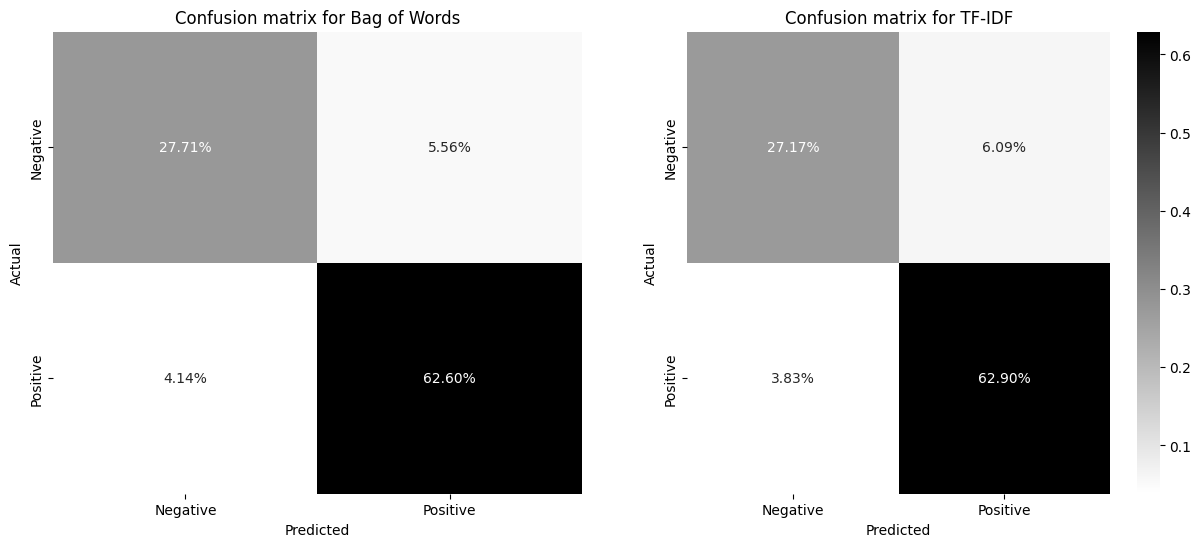

In [150]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

cm_bow=confusion_matrix(test_sentiments,lr_bow_predict)
# create heatmap
sns.heatmap(cm_bow/np.sum(cm_bow), annot=True, fmt='.2%', cmap='binary', cbar=False, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Confusion matrix for Bag of Words')

cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict)
sns.heatmap(cm_tfidf/np.sum(cm_tfidf), annot=True, fmt='.2%', cmap='binary', cbar=True, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title('Confusion matrix for TF-IDF')

plt.show()

## **ROC Curves** https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
- ### This code computes the Area Under the Curve (AUC) for the logistic regression models and displays the Receiver Operating Characteristic (ROC) curves.
- ### ROC curves illustrate the models' behavior across different classification thresholds, helping in threshold optimization.
    - A higher AUC value indicates better model performance in distinguishing between classes. 

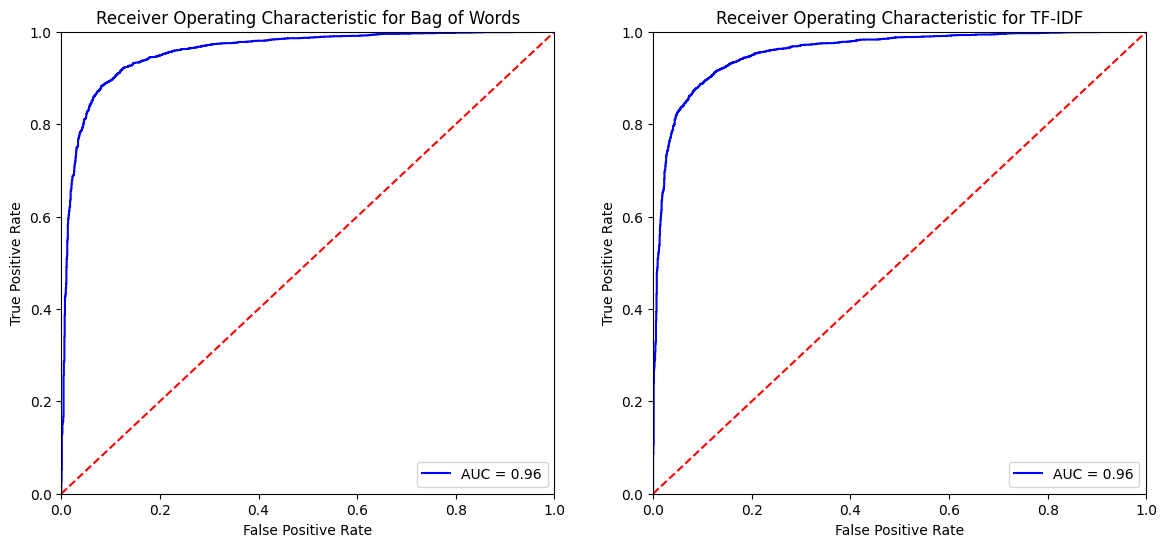

In [151]:
#ROC-AUC curve for bag of words
probs_bow = lr_bow.predict_proba(bow_test_reviews)
preds_bow = probs_bow[:,1]
fpr_lr_bow, trp_lr_bow, thresholds_lr_bow = roc_curve(test_sentiments, preds_bow)
roc_auc_lr_bow = auc(fpr_lr_bow, trp_lr_bow)
#ROC-AUC curve for tfidf features
probs_tfidf = lr_tfidf.predict_proba(tif_test_reviews)
preds_tfidf = probs_tfidf[:,1]
fpr_lr_tfidf, trp_lr_tfidf, thresholds_lr_tfidf = roc_curve(test_sentiments, preds_tfidf)
roc_auc_lr_tfidf = auc(fpr_lr_tfidf, trp_lr_tfidf)

#Plotting the ROC curves
plt.figure(figsize=(14, 6))
subplot = plt.subplot(1, 2, 1)
plt.title('Receiver Operating Characteristic for Bag of Words')
plt.plot(fpr_lr_bow, trp_lr_bow, 'b', label = 'AUC = %0.2f' % roc_auc_lr_bow)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

subplot = plt.subplot(1, 2, 2)
plt.title('Receiver Operating Characteristic for TF-IDF')
plt.plot(fpr_lr_tfidf, trp_lr_tfidf, 'b', label = 'AUC = %0.2f' % roc_auc_lr_tfidf)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# **Stohastic Gradient Descent Model**

## Training 

In [152]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=100,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(bow_train_reviews, train_sentiments)
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(bow_train_reviews, train_sentiments)
print(svm_tfidf)

SGDClassifier(max_iter=100, random_state=42)
SGDClassifier(max_iter=100, random_state=42)


## Testing

In [153]:
#Predicting the model for bag of words
svm_bow_predict=svm.predict(tif_test_reviews)
print(svm_bow_predict)
##Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tif_test_reviews)
print(svm_tfidf_predict)

[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]


## Accuracy

In [154]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

svm_bow_score : 0.6673692278214217
svm_tfidf_score : 0.6673692278214217


## Classification Report

In [155]:
# Classification report for bag of words 
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=['Negative','Positive'])
print(svm_bow_report)

# Classification report for tfidf features
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Negative','Positive'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      1736
    Positive       0.67      1.00      0.80      3483

    accuracy                           0.67      5219
   macro avg       0.33      0.50      0.40      5219
weighted avg       0.45      0.67      0.53      5219

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      1736
    Positive       0.67      1.00      0.80      3483

    accuracy                           0.67      5219
   macro avg       0.33      0.50      0.40      5219
weighted avg       0.45      0.67      0.53      5219



## Confusion Matrix

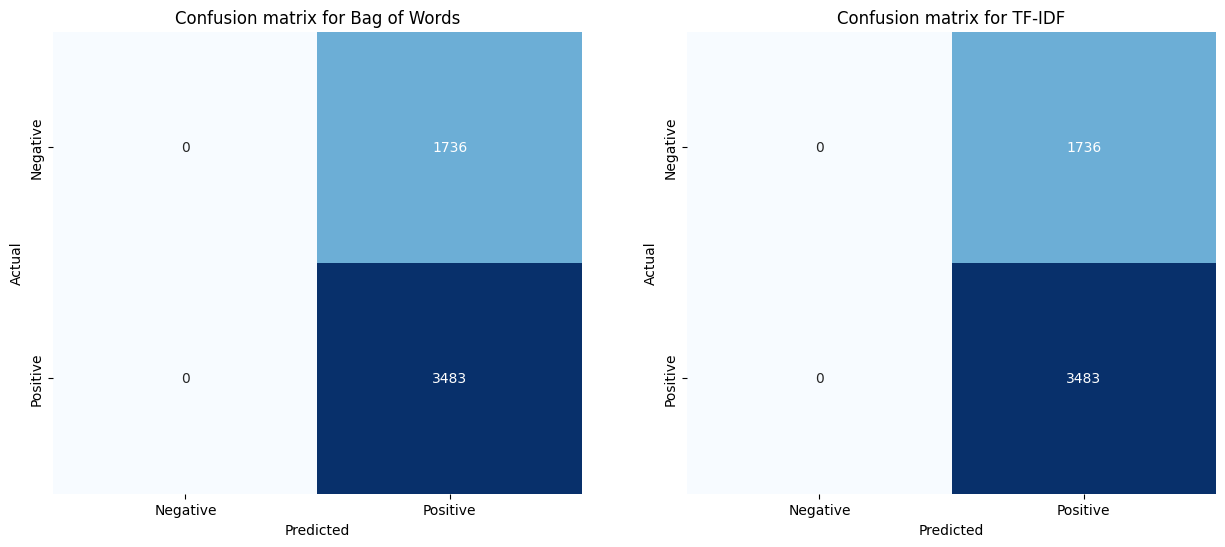

In [156]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

cm_bow2=confusion_matrix(test_sentiments,svm_bow_predict)
# create heatmap
sns.heatmap(cm_bow2, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Confusion matrix for Bag of Words')

cm_tfidf2=confusion_matrix(test_sentiments,svm_tfidf_predict)
sns.heatmap(cm_tfidf2, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title('Confusion matrix for TF-IDF')

plt.show()

# **Multinomial Naive Bayes Model**

## Training

In [157]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(bow_train_reviews,train_sentiments)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(bow_train_reviews,train_sentiments)
print(mnb_tfidf)

MultinomialNB()
MultinomialNB()


## Testing

In [158]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(tif_test_reviews)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tif_test_reviews)
print(mnb_tfidf_predict)

[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]


## Accuracy

In [159]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.8771795363096379
mnb_tfidf_score : 0.8771795363096379


## Classification Report

In [160]:
#Classification report for bag of words 
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Negative','Positive'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Negative','Positive'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Negative       0.89      0.72      0.79      1736
    Positive       0.87      0.96      0.91      3483

    accuracy                           0.88      5219
   macro avg       0.88      0.84      0.85      5219
weighted avg       0.88      0.88      0.87      5219

              precision    recall  f1-score   support

    Negative       0.89      0.72      0.79      1736
    Positive       0.87      0.96      0.91      3483

    accuracy                           0.88      5219
   macro avg       0.88      0.84      0.85      5219
weighted avg       0.88      0.88      0.87      5219



## Confusion Matrix

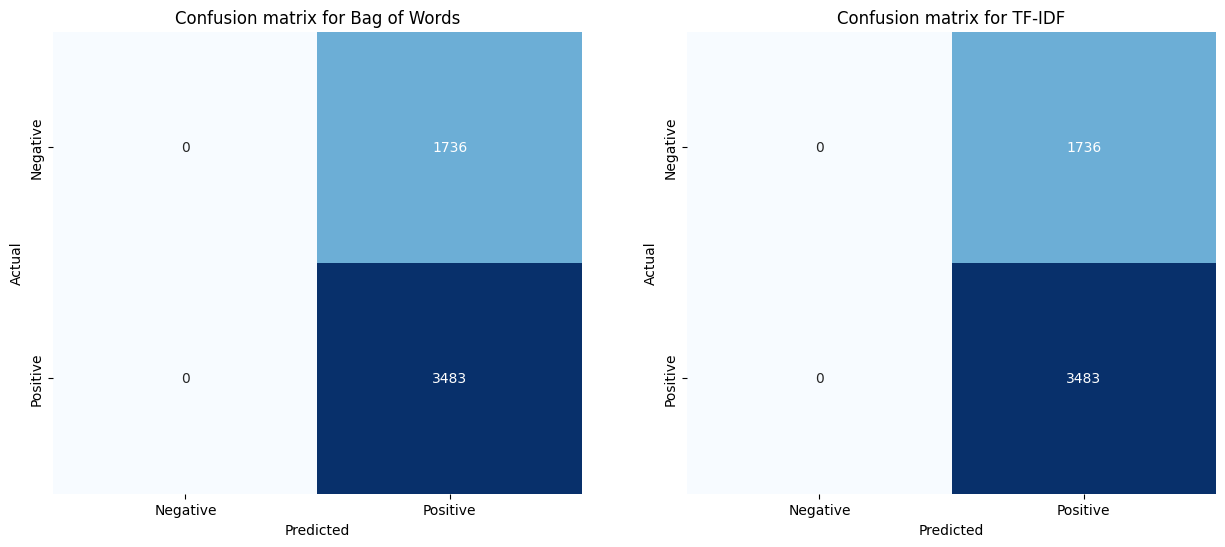

In [161]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

cm_bow3=confusion_matrix(test_sentiments,mnb_bow_predict)
# create heatmap
sns.heatmap(cm_bow2, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Confusion matrix for Bag of Words')

cm_tfidf3=confusion_matrix(test_sentiments,mnb_tfidf_predict)
sns.heatmap(cm_tfidf2, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'], ax=ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title('Confusion matrix for TF-IDF')

plt.show()